# Neural Network Model Training

In [106]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'cuda'

In [107]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

path = "../../../"

training_data = datasets.FashionMNIST(
    root=path,
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.FashionMNIST(
    root=path,
    train=False,
    download=True,
    transform=transform
)

# 교차 검증을 해볼 예정이라 training_data는 dataloader로 사용하지 않는다(train, val 찢고 따로 dataloader 정의할 예정).

test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Model 정의 및 Cross Validation 실행
### Cross Validation
training_data를 KFold를 이용해서 n-fold의 subset으로 나눈 뒤 dataloader 정의.

In [108]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(28*28, 100)
        self.linear2 = nn.Linear(100, 10)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.softmax(self.linear2(x))
        return x

In [109]:
import torch
import torch.nn as nn
import torch.optim as optim

def CrossValidation(model, train_loader, val_loader, num_epochs=5, learning_rate=0.001):
    # 손실 함수 및 최적화 알고리즘 설정
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 각 에폭에 대한 리스트 초기화
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # 훈련 모드로 설정
        model.train()

        # 훈련 데이터에 대한 에폭 내 손실 누적
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device).reshape(-1, 28*28)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        # 평균 훈련 손실 계산
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # 검증 모드로 설정
        model.eval()

        # 검증 데이터에 대한 손실 누적
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device).reshape(-1, 28*28)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)

        # 평균 검증 손실 계산
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        # 에폭마다 손실 출력
        print(f'Epoch {epoch+1}/{num_epochs} => '
              f'Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    return train_losses, val_losses


In [110]:
def eval(model, dataloader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            inputs, targets = data
            inputs = inputs.to(device).reshape(-1, 28*28)
            targets = targets.to(device)
            outputs = model(inputs)
            
            predicted = torch.argmax(outputs.data, 1).to(device)
            correct += predicted.eq(targets.data.view_as(predicted)).sum()
            
    data_num = len(dataloader.dataset)
    print("Acuraccy in test : {}/{} ({:.0f}%)".format(correct, data_num, 100*correct/data_num))

Fold 1


C:\Users\민재\AppData\Local\Temp\ipykernel_9332\2991853494.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.linear2(x))


Epoch 1/5 => Training Loss: 1.7067, Validation Loss: 1.6461
Epoch 2/5 => Training Loss: 1.6319, Validation Loss: 1.6176
Epoch 3/5 => Training Loss: 1.6166, Validation Loss: 1.6157
Epoch 4/5 => Training Loss: 1.6078, Validation Loss: 1.6020
Epoch 5/5 => Training Loss: 1.6033, Validation Loss: 1.5981
Fold 2
Epoch 1/5 => Training Loss: 1.5974, Validation Loss: 1.5988
Epoch 2/5 => Training Loss: 1.5913, Validation Loss: 1.5971
Epoch 3/5 => Training Loss: 1.5890, Validation Loss: 1.5965
Epoch 4/5 => Training Loss: 1.5841, Validation Loss: 1.5997
Epoch 5/5 => Training Loss: 1.5819, Validation Loss: 1.5881
Fold 3
Epoch 1/5 => Training Loss: 1.5833, Validation Loss: 1.5752
Epoch 2/5 => Training Loss: 1.5783, Validation Loss: 1.5902
Epoch 3/5 => Training Loss: 1.5776, Validation Loss: 1.5820
Epoch 4/5 => Training Loss: 1.5750, Validation Loss: 1.5848
Epoch 5/5 => Training Loss: 1.5718, Validation Loss: 1.5794
Fold 4
Epoch 1/5 => Training Loss: 1.5727, Validation Loss: 1.5706
Epoch 2/5 => Traini

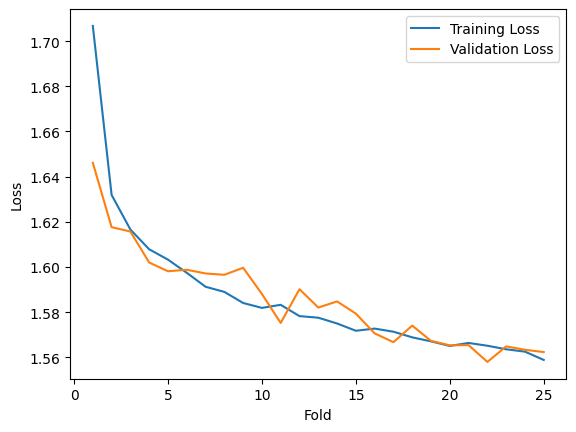

In [111]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset, DataLoader

n = 5
kfold = StratifiedKFold(n_splits=n, shuffle=True, random_state=42)

model = Classifier().to(device)
train_losses, val_losses = [], []

# 데이터셋을 교차 검증용으로 나누기
for fold, (train_idx, val_idx) in enumerate(kfold.split(training_data.data, training_data.targets)):
    print(f"Fold {fold + 1}")

    # 데이터 로더 생성
    train_dataset = Subset(training_data, train_idx)
    val_dataset = Subset(training_data, val_idx)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # 여기에서 모델 훈련 및 평가 수행
    train_loss, val_loss = CrossValidation(model, train_loader, val_loader, num_epochs=n)
    
    # ...
    '''
    # 예시: 각 폴드에서 첫 번째 배치의 데이터 출력
    for batch in train_loader:
        inputs, labels = batch
        print(f"Train Batch - Inputs Shape: {inputs.shape}, Labels Shape: {labels.shape}")
        break

    for batch in val_loader:
        inputs, labels = batch
        print(f"Validation Batch - Inputs Shape: {inputs.shape}, Labels Shape: {labels.shape}")
        break
    '''
    
    train_losses = train_losses + train_loss
    val_losses = val_losses + val_loss
# 교차 검증 결과 시각화
import matplotlib.pyplot as plt

plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Dropout 적용

In [112]:
class ClassifierWithDropout(nn.Module):
    def __init__(self, dropout_prob = 0.3):
        super().__init__()
        self.linear1 = nn.Linear(28*28, 100)
        self.dropout = nn.Dropout(p = dropout_prob)
        self.linear2 = nn.Linear(100, 10)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.softmax(self.linear2(x))
        return x

C:\Users\민재\AppData\Local\Temp\ipykernel_9332\1587905957.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.linear2(x))


Accuracy in epoch  1 : 35518/48000 (74.00%)
Accuracy in epoch  2 : 39063/48000 (81.38%)
Accuracy in epoch  3 : 39864/48000 (83.05%)
Accuracy in epoch  4 : 40348/48000 (84.06%)
Accuracy in epoch  5 : 40628/48000 (84.64%)
Accuracy in epoch  6 : 40795/48000 (84.99%)
Accuracy in epoch  7 : 40998/48000 (85.41%)
Accuracy in epoch  8 : 41153/48000 (85.74%)
Accuracy in epoch  9 : 41243/48000 (85.92%)
Accuracy in epoch 10 : 41457/48000 (86.37%)


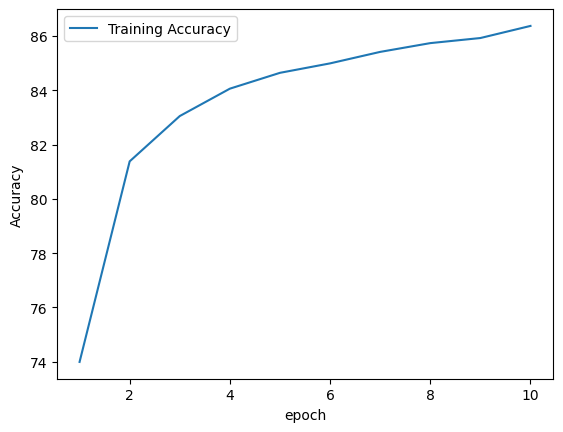

In [113]:
Acc_list = []

def train(epoch, model, dataloader):
    cnt = 0
    Accuracy = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.000523)
    
    for cnt in range(epoch):
        model.train()
        correct = 0
        
        for data, targets in dataloader:
            data = data.reshape(-1, 28*28).to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            predicted = torch.argmax(outputs.data, 1)
            correct += predicted.eq(targets.data.view_as(predicted)).sum()
        
        data_num = len(dataloader.dataset)
        cnt += 1
        accuracy = 100 * correct.to('cpu') / data_num # 뒤에 계산 때문에 cpu로 옮김.
        print("Accuracy in epoch {:2d} : {}/{} ({:.2f}%)".format(cnt, correct, data_num, accuracy))
        Accuracy.append(accuracy)
    
    return Accuracy

model = ClassifierWithDropout().to(device)

acc = train(10, model, train_loader)

plt.plot(range(1, len(acc) + 1), acc, label='Training Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Model Save & Load

In [114]:
# 모델과 옵티마이저 상태를 저장
model = ClassifierWithDropout().to(device)
epoch = 5
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'model_checkpoint.pth')
eval(model, test_dataloader)

C:\Users\민재\AppData\Local\Temp\ipykernel_9332\1587905957.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.linear2(x))


Acuraccy in test : 1042/10000 (10%)


In [115]:
new_model = ClassifierWithDropout().to(device)

# 저장된 모델과 옵티마이저 상태 불러오기
checkpoint = torch.load('model_checkpoint.pth')
new_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

# 모델을 평가 또는 추가 훈련에 사용 가능
eval(new_model, test_dataloader)
eval(model, test_dataloader)

C:\Users\민재\AppData\Local\Temp\ipykernel_9332\1587905957.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.linear2(x))


Acuraccy in test : 1042/10000 (10%)
Acuraccy in test : 1042/10000 (10%)
